# Using MCMC in Fitr with your own Stan Code

While we aim to endow `fitr` with a large library of likelihood functions and generative models for most popular behavioural tasks, at this early stage we only have a couple. Moreover, one might be interested in creating a new task or writing a likelihood function that does not yet exist. This tutorial will show you how this can be done and embedded within the `fitr` workflow. 

Why not just use Stan, you ask? Well, that would be certainly an excellent option. However, with `fitr`, we aim to do more than just model fitting, and include many other helpful functions that can simplify the behavioural modelling workflow. As such, although we use Stan as our MCMC engine, we seek to write functions that highlight only those parts that are most important for the modeling of behavioural data. 

In [1]:
import numpy as np 

import fitr
from fitr.rlparams import *
from fitr import tasks
from fitr import generative_models as gm

# Generate some data to fit

For simplicity, we will use the two armed bandit task, as in our other examples.

In [2]:
group = generate_group(params=[LearningRate(), ChoiceRandomness()], nsubjects=50)
taskdata = tasks.bandit(narms=2).simulate(params=group, ntrials=50)

# Create a Generative Model

Here, we will borrow the code from one of the generative models we have specified for the 2-armed bandit, and create a `GenerativeModel()` object. Fitr uses such an object in order to store additional information about which parameters to extract from the Stan output. This aims to streamline the process of analyzing results of model fitting, handling a lot of the gruntwork behind the scenes.

In [3]:
my_gm = gm.GenerativeModel()

In [4]:
my_gm.model = """
data {
    int<lower=1> N;
    int<lower=1> T;
    int<lower=1,upper=2> A[T, N];
    real R[T, N];
}
transformed data {
    vector[2] Q_o;
    Q_o = rep_vector(0.0, 2);
}
parameters {
    vector[2] mu_p;
    vector<lower=0>[2] sigma;

    vector[N] lr_pr;
    vector[N] cr_pr;
}
transformed parameters {
    vector<lower=0, upper=1>[N] lr;
    vector<lower=0, upper=10>[N] cr;

    for (i in 1:N) {
        lr[i] = Phi_approx(mu_p[1] + sigma[1]*lr_pr[i]);
        cr[i] = Phi_approx(mu_p[2] + sigma[2]*cr_pr[i])*10;
    }
}
model {
    # Hyperparameters
    mu_p ~ normal(0, 1);
    sigma ~ cauchy(0, 5);

    # Individual parameters
    lr_pr ~ normal(0, 1);
    cr_pr ~ normal(0, 1);

    # Subject and trial loops
    for (i in 1:N) {
        vector[2] Q;
        real PE;

        Q = Q_o;

        for (t in 1:T) {
            # Action probability
            A[t, i] ~ categorical_logit(cr[i]*Q);

            # Prediction error
            PE = R[t, i] - Q[A[t, i]];

            # Learning
            Q[A[t, i]] = Q[A[t, i]] + lr[i]*PE;
        }
    }
}
"""

The `GenerativeModel()` object also needs us to tell it which parameters are in the model. We do this as follows:

In [5]:
my_gm.paramnames = {
    'long' : ['Learning Rate', 'Choice Randomness'], 
    'code' : ['lr', 'cr']
}

We specified this in a dictionary with two keys: 'long' which sets names to be used in plotting and other summary functions, and 'code', which identifies the names of the parameters that we have set in the Stan code.

Now we are ready to fit the model.

In [6]:
lrcr = fitr.MCMC(generative_model=my_gm).fit(data=taskdata.data_mcmc, n_iterations=100)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c95e6e3689e16adc7f5b632c185ae952 NOW.


Let's plot the results now.

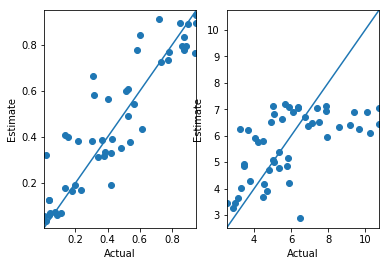

In [7]:
lrcr.plot_ae(actual=group)

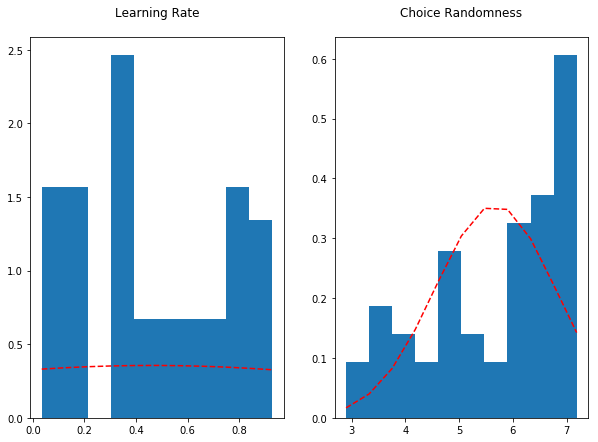

In [8]:
lrcr.param_hist()

We can also access Stan's traceplot directly (we're working on nice and easy wrappers for this).

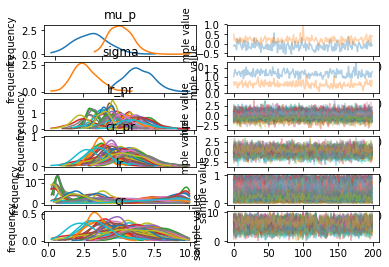

In [9]:
lrcr.stanfit['stanfit'].plot()